In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, model_selection

from tensorflow import keras
from tensorflow.keras import layers

from keras.wrappers.scikit_learn import KerasClassifier

Example image of 0 digit


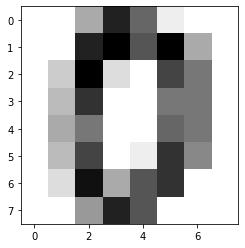

In [2]:
# Load dataset
digits = datasets.load_digits()

print('Example image of', digits.target[0], 'digit')
plt.imshow(digits.images[0], cmap='gray_r')

plt.show()

In [3]:
# Prepare the data and the splitter
n_classes = len(digits.target_names)
n_features = digits.data.shape[1:]

X = digits.data/digits.data.max()
y = digits.target

X_trainval, X_test, y_trainval, y_test = (model_selection.
                                          train_test_split(X, y, stratify=y,
                                                            random_state=0))

y_trainval = keras.utils.to_categorical(y_trainval, num_classes=n_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=n_classes)

splitter = model_selection.StratifiedShuffleSplit(1, random_state=0)

In [4]:
# Define sklearn classifier
def make_model(hidden_units1, hidden_units2, l2_strength):
    model = keras.Sequential(
        [
        layers.InputLayer(input_shape=n_features),
        layers.Dense(hidden_units1, activation='relu', 
                     kernel_regularizer=keras.regularizers.l2(l2_strength)),
        layers.Dense(hidden_units2, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(l2_strength)),
        layers.Dense(n_classes, activation='softmax',
                     kernel_regularizer=keras.regularizers.l2(l2_strength))
        ]
    )

    model.compile(optimizer='adam', loss="categorical_crossentropy",
                  metrics=['accuracy'])
    
    return model


class SilentKerasClassifier(KerasClassifier):

    def fit(self, X, y):
      return super().fit(X, y , verbose=0)

    def score(self, X, y):
      return super().score(X, y, verbose=0)


model = SilentKerasClassifier(make_model)

In [5]:
# Grid search
param_grid = {
    'hidden_units1': (n_features * np.logspace(0, 8, num=5, base=2)).tolist(),
    'hidden_units2': (n_features * np.logspace(-1, 7, num=5, base=2)).tolist(),
    'l2_strength': np.logspace(-10, 0, num=5).tolist()
}

display(pd.DataFrame.from_dict(param_grid, orient='index').add_prefix('value '))

grid = model_selection.GridSearchCV(model, param_grid=param_grid, cv=splitter,
                                    return_train_score=True)
grid.fit(X_trainval, y_trainval)

res = pd.DataFrame(grid.cv_results_)[['param_hidden_units1', 
                                      'param_hidden_units2',
                                      'param_l2_strength',
                                      'mean_train_score',
                                      'mean_test_score']]

res.sort_values(by=['mean_test_score', 'mean_train_score'], ascending=False, 
                inplace=True)

res[:10]

,value 0,value 1,value 2,value 3,value 4
hidden_units1,6.400000e+01,2.560000e+02,1024.00000,4096.000000,16384.0
hidden_units2,3.200000e+01,1.280000e+02,512.00000,2048.000000,8192.0
l2_strength,1.000000e-10,3.162278e-08,0.00001,0.003162,1.0


,param_hidden_units1,param_hidden_units2,param_l2_strength,mean_train_score,mean_test_score
90,4096,2048,1e-10,0.971947,0.985185
97,4096,8192,1e-05,0.972772,0.970370
70,1024,8192,1e-10,0.962871,0.970370
88,4096,512,0.00316228,0.945545,0.970370
118,16384,2048,0.00316228,0.933993,0.970370
96,4096,8192,3.16228e-08,0.967822,0.962963
120,16384,8192,1e-10,0.952145,0.962963
73,1024,8192,0.00316228,0.947195,0.962963
67,1024,2048,1e-05,0.943894,0.962963
85,4096,512,1e-10,0.938944,0.962963


In [6]:
# Evaluate performance on the test set
print(grid.score(X_test, y_test))

0.9377777576446533
